In [48]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import datetime
from jupyterthemes import jtplot

In [44]:
# Import data
csv_path = 'GDA_DATA.csv'
df = pd.read_csv(csv_path, encoding='ISO-8859-1')

In [3]:
# Rename Columns
col_name = ['trip_id', 'duration', 'start_date', 'start_station', 'start_terminal', 'end_date', 'end_station', 'end_terminal', 'bike_no', 'subscriber_type', 'zip_code']
df.columns = col_name
df.head()

,trip_id,duration,start_date,start_station,start_terminal,end_date,end_station,end_terminal,bike_no,subscriber_type,zip_code
0,432946,406,8/31/2014 22:31,Mountain View Caltrain Station,28,8/31/2014 22:38,Castro Street and El Camino Real,32,17,Subscriber,94040
1,432945,468,8/31/2014 22:07,Beale at Market,56,8/31/2014 22:15,Market at 4th,76,509,Customer,11231
2,432944,534,8/31/2014 22:06,Beale at Market,56,8/31/2014 22:15,Market at 4th,76,342,Customer,11231
3,432942,1041,8/31/2014 21:45,Embarcadero at Sansome,60,8/31/2014 22:02,Steuart at Market,74,603,Customer,94521
4,432941,1091,8/31/2014 21:44,Embarcadero at Sansome,60,8/31/2014 22:02,Steuart at Market,74,598,Customer,94521


# Functions

In [4]:
# Extract Time
def get_time(date_time):
    reformatted_time = datetime.datetime.strptime(date_time, '%m/%d/%Y %H:%M')
    reformatted_time = reformatted_time.strftime("%H:00")
    return reformatted_time

In [5]:
# Plot Supply vs Demand given Station
def plt_supply_demand(station):
    # Set up axis
    x_axis = top_stations_df.time
    y_axis_demand = top_stations_df.loc[top_stations_df.station == station].demand_count
    y_axis_supply = top_stations_df.loc[top_stations_df.station == station].supply_count
    #Plot
    fig, ax = plt.subplots(1, 1, figsize=(30, 10))
    fig.suptitle("Bike Share Hourly Supply vs Demand @ "+station, fontsize=24, fontweight="bold")
    colors = {'Supply':'lightblue', 'Demand':'lightcoral'}
    ax.plot(x_axis[top_stations_df.station == station], y_axis_demand[top_stations_df.station == station], marker="o", c="lightcoral", linewidth=7.0, alpha=0.75, label = "Demand")
    ax.plot(x_axis[top_stations_df.station == station], y_axis_supply[top_stations_df.station == station], marker="o", c="lightblue", linewidth=7.0, alpha=0.75, label = "Supply")
    
    plt.legend(loc="upper left", fancybox=True)
    
    # Set Style
    jtplot.style(theme='onedork')
    plt.show()

In [6]:
# Calculate Safety Stock. Inventory Targt = Run Rate + Safety Stock
def calc_safety_stock(sl, avg_d, std_d, avg_s, std_s):
    ss = stats.norm.ppf(sl)*np.sqrt((avg_d**2)*(std_s**2) + avg_s*(std_d**2))
    return ss


# Identify High Demand & Supply Stations

## Extract Time

In [7]:
df['start_time'] = df.start_date.apply(get_time)
df['end_time'] = df.end_date.apply(get_time)

In [8]:
df.head()

,trip_id,duration,start_date,start_station,start_terminal,end_date,end_station,end_terminal,bike_no,subscriber_type,zip_code,start_time,end_time
0,432946,406,8/31/2014 22:31,Mountain View Caltrain Station,28,8/31/2014 22:38,Castro Street and El Camino Real,32,17,Subscriber,94040,22:00,22:00
1,432945,468,8/31/2014 22:07,Beale at Market,56,8/31/2014 22:15,Market at 4th,76,509,Customer,11231,22:00,22:00
2,432944,534,8/31/2014 22:06,Beale at Market,56,8/31/2014 22:15,Market at 4th,76,342,Customer,11231,22:00,22:00
3,432942,1041,8/31/2014 21:45,Embarcadero at Sansome,60,8/31/2014 22:02,Steuart at Market,74,603,Customer,94521,21:00,22:00
4,432941,1091,8/31/2014 21:44,Embarcadero at Sansome,60,8/31/2014 22:02,Steuart at Market,74,598,Customer,94521,21:00,22:00


## Identify Top 5 Demand Station

In [9]:
rank_demand_df = df.groupby(['start_station','start_terminal']).count()
rank_demand_df = pd.DataFrame(rank_demand_df['start_date'])
rank_demand_df.sort_values(by=['start_date'],ascending=False,inplace=False).head()

,,start_date
start_station,start_terminal,
San Francisco Caltrain (Townsend at 4th),70,12950
Harry Bridges Plaza (Ferry Building),50,8336
Embarcadero at Sansome,60,7010
San Francisco Caltrain 2 (330 Townsend),69,7008
2nd at Townsend,61,6824


## Identify Top 5 Supply Station

In [10]:
rank_supply_df = df.groupby(['end_station','end_terminal']).count()
rank_supply_df = pd.DataFrame(rank_supply_df['end_date'])
rank_supply_df.sort_values(by=['end_date'],ascending=False,inplace=False).head()

,,end_date
end_station,end_terminal,
San Francisco Caltrain (Townsend at 4th),70,16732
Embarcadero at Sansome,60,8141
Harry Bridges Plaza (Ferry Building),50,7908
Market at Sansome,77,7879
San Francisco Caltrain 2 (330 Townsend),69,7482


## Work on Top 3 Stations 
### (San Francisco Caltrain (Townsend at 4th), Embarcadero at Sansome, Harry Bridges Plaza (Ferry Building))

### Definition: 
*  Demand: Number of bikes checked out from a station
*  Supply: Number of bikes returned to a station

In [11]:
# To Merge the DFs: Extract and change columns to the same column names
demand_df = df.loc[:,['start_terminal','start_station','start_time', 'trip_id']]
demand_df.rename(columns = {
                            'start_terminal': 'terminal',
                            'start_station': 'station',
                            'start_time': 'time',
                            'trip_id': 'demand_count'
                            },
                            inplace = True
                )
# Get count for each station and each time
grouped_demand_df = demand_df.groupby(['terminal', 'station', 'time'])
grouped_demand_count_df = grouped_demand_df.count()
demand_df = grouped_demand_count_df.reset_index()

In [12]:
# To Merge the DFs: Extract and change columns to the same column names
supply_df = df.loc[:,['end_terminal', 'end_station','end_time', 'trip_id']]
supply_df.rename(columns = {
                            'end_terminal': 'terminal',
                            'end_station': 'station',
                            'end_time': 'time',
                            'trip_id': 'supply_count'
                            },
                            inplace = True
                )
# Get count for each station and each time
grouped_supply_df = supply_df.groupby(['terminal', 'station', 'time'])
grouped_supply_count_df = grouped_supply_df.count()
supply_df = grouped_supply_count_df.reset_index()

In [13]:
stations_df = pd.merge(demand_df, supply_df, on = ['terminal', 'station', 'time'], how = 'inner')

### Normalize the DataFrame to Reflect Daily Demand and Supply

### Notes:
- The data provides 184 days of data (from Mar 1st to Sep 1st). To show daily run rate for demand and supply, I **divide the count columns by 184 days**

In [14]:
# Calculate Number of Days in the original dataset
dates_df = pd.concat([df.start_date,df.end_date])
max_date = datetime.datetime.strptime(dates_df.max(), '%m/%d/%Y %H:%M')
min_date = datetime.datetime.strptime(dates_df.min(), '%m/%d/%Y %H:%M')
num_days = (max_date - min_date).days
normalize_daily = lambda x:round(x/num_days,2)

In [15]:
# Normalize the demand and supply columns
stations_df.demand_count = stations_df.demand_count.apply(normalize_daily)
stations_df.supply_count = stations_df.supply_count.apply(normalize_daily)

In [16]:
top_stations_df = stations_df.set_index('terminal')
top_stations_df = top_stations_df.loc[[70, 50, 60],:]
top_stations_df = top_stations_df.reset_index()
top_stations_df.head(24)

,terminal,station,time,demand_count,supply_count
0,70,San Francisco Caltrain (Townsend at 4th),00:00,0.14,0.14
1,70,San Francisco Caltrain (Townsend at 4th),01:00,0.08,0.11
2,70,San Francisco Caltrain (Townsend at 4th),02:00,0.04,0.04
3,70,San Francisco Caltrain (Townsend at 4th),03:00,0.01,0.01
4,70,San Francisco Caltrain (Townsend at 4th),04:00,0.01,0.03
5,70,San Francisco Caltrain (Townsend at 4th),05:00,0.22,0.10
6,70,San Francisco Caltrain (Townsend at 4th),06:00,2.96,1.72
7,70,San Francisco Caltrain (Townsend at 4th),07:00,11.55,6.16
8,70,San Francisco Caltrain (Townsend at 4th),08:00,17.79,9.08
9,70,San Francisco Caltrain (Townsend at 4th),09:00,9.25,4.61


# Identify Supply and Demand Gap

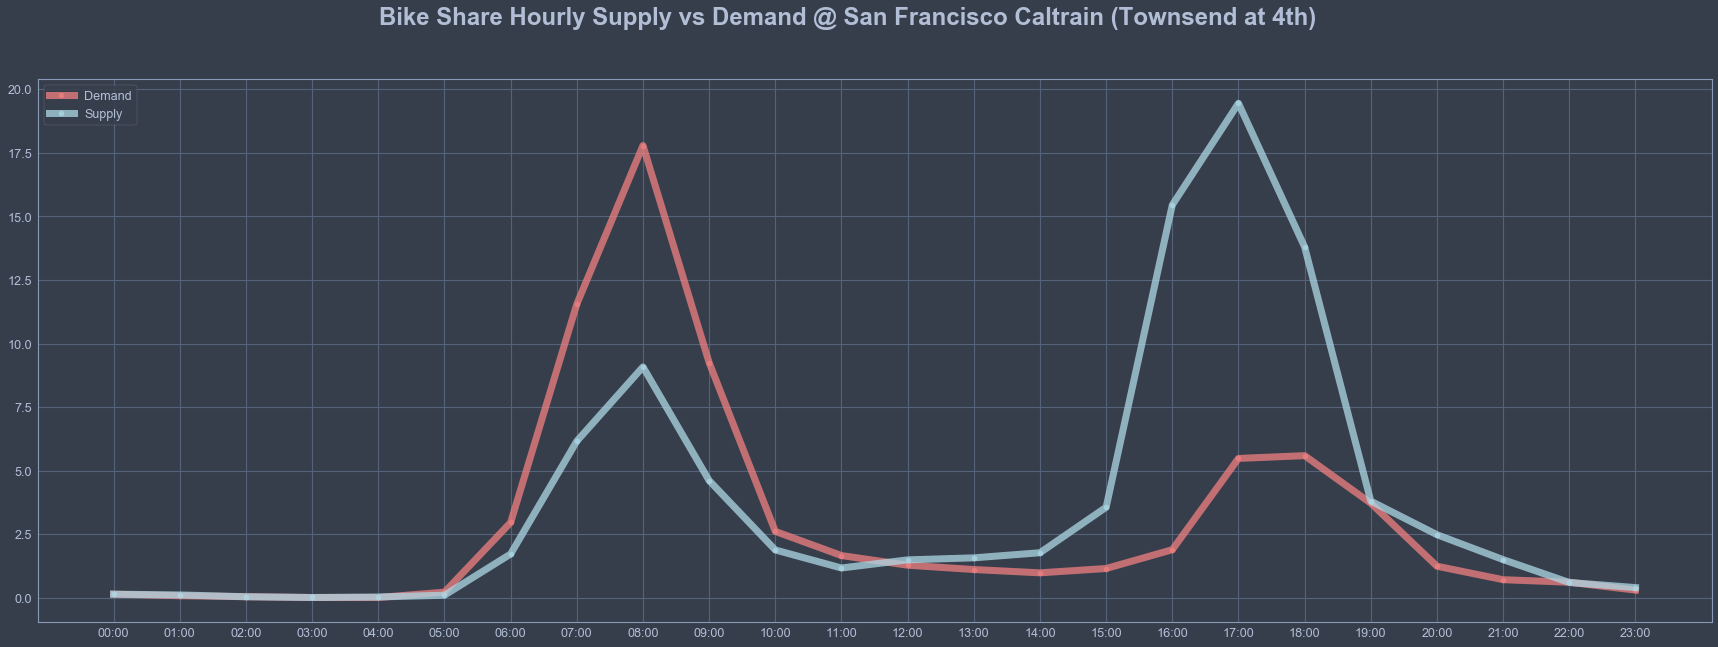

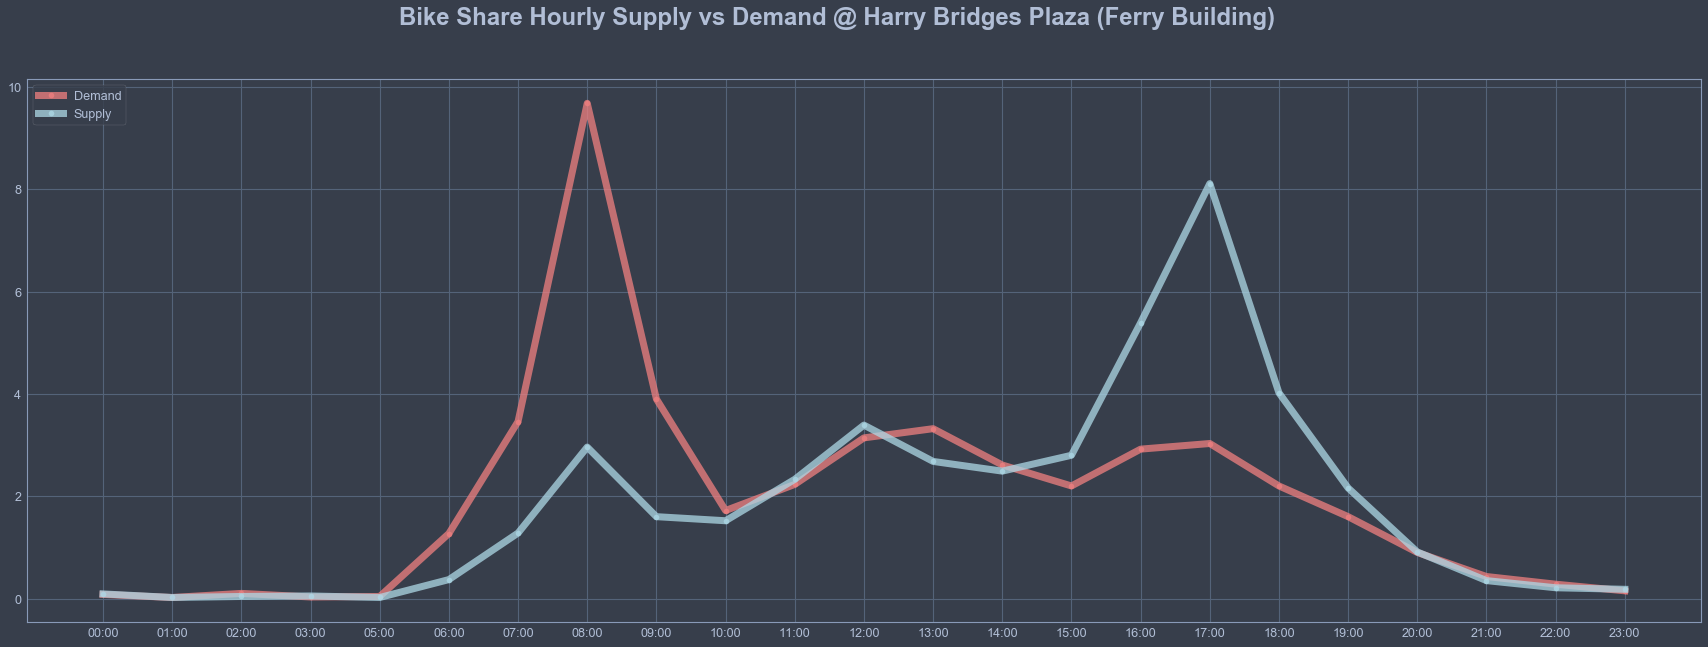

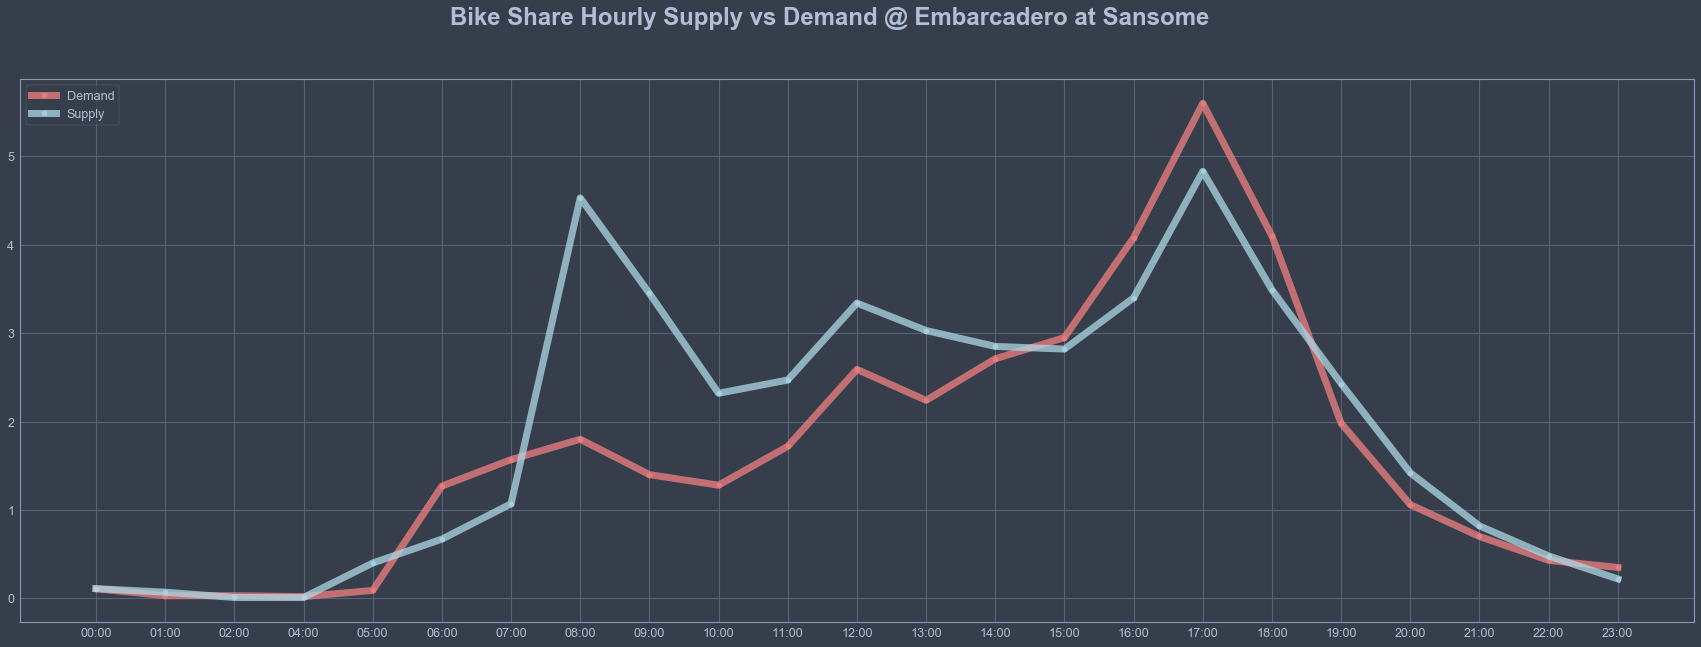

In [45]:
station_list = top_stations_df.station.unique()
for station in station_list:
    plt_supply_demand(station)

## Problem Statement: Inbalanced Supply and Demand
The issue that I encountered in the past for bike rental is that all the bikes were checked out or the racks were full when returning the bike. Therefore, I decided to dig deeper on the issue of supply and demand gap. The charts above show there is indeed supply and demand gaps for top 3 major bike stations.

## Mission Statement: Suggest a Quantified Solution to Bridge Supply and Dmand Gap
I applied the supply chain knowledge of inventory target to prevent the events of stockout (no bikes available) or surplus (racks are full)

## Validation: Hopythesis Testing
To experiment the solution soundess, I designed a Time Series 1-sided T-Test to validate if the inventory sugestion indeed lowers the supply and demand gaps.

## Tool: Dashboard
A dashboard is designed to coninue the experiment through time.


# Suggest Hourly Bikes Inventory Target to Improve Utilization at each Station

## Calculate the Optimal Inventory Level
### Notes:
- Predicting the hourly inventory target at each station can prevent bikes shortage or surplus at any bike station

### Steps:
1. Measure Demand and Supply Variabilities
2. Define Service Level for each hour at each station (How well do we want to service our customer)
3. Calculate Safety Stock and Optimal Inventory Level (# of bikes to hold to prevent stockout) 

### Formula:
- **Inventory Target (IT) = Average Hourly Run Rate (AHR) + Safety Stock (SS)**
   - AHR = demand_avg
   - SS = service level(%) * the vector of demand and supply variabilities
       - Variability can be measured by historical demand (# of bikes checked out) and supply (# of bikes returned) using **mean** and **std**
- The Supply vs Demand Graphs show there are two peaks in supply and demand throughout the day.
   - To better measure the supply and demand variabilities, I split the daily dataframe into AM and PM
    

In [18]:
inv_target_am_df = stations_df.loc[stations_df.time < '13:00']
inv_target_pm_df = stations_df.loc[stations_df.time >= '13:00']

## Step 1: Measure the Demand and Supply Variabilities: Calculate mean and std for each station

#### Calculate meand and std for DataFrame AM

In [19]:
grouped_inv_target_am_df = inv_target_am_df.groupby(['terminal', 'station'])
#avg
avg_df = grouped_inv_target_am_df.mean()
avg_df = avg_df.reset_index()
avg_df = avg_df.rename(columns={'demand_count': 'demand_avg',
                                'supply_count': 'supply_avg'}
                                )
#std
std_df = grouped_inv_target_am_df.std().fillna(grouped_inv_target_am_df.last())
std_df = std_df.reset_index()
std_df = std_df.rename(columns={'demand_count': 'demand_std',
                                'supply_count': 'supply_std'}
                                )
inv_target_am_df = pd.merge(avg_df, std_df, on=['terminal', 'station'], how = 'inner')

In [20]:
inv_target_am_df.head()

,terminal,station,demand_avg,supply_avg,demand_std,supply_std
0,2,San Jose Diridon Caltrain Station,0.687000,0.500000,0.817938,0.659983
1,3,San Jose Civic Center,0.113750,0.101250,0.102670,0.083399
2,4,Santa Clara at Almaden,0.143636,0.255455,0.127536,0.339834
3,5,Adobe on Almaden,0.058571,0.190000,0.069625,0.151217
4,6,San Pedro Square,0.080000,0.175455,0.051962,0.225671


#### Calculate mean and std for DataFrame PM

In [21]:
grouped_inv_target_pm_df = inv_target_pm_df.groupby(['terminal', 'station'])
#avg
avg_df = grouped_inv_target_pm_df.mean()
avg_df = avg_df.reset_index()
avg_df = avg_df.rename(columns={'demand_count': 'demand_avg',
                                'supply_count': 'supply_avg'}
                                )
#std
std_df = grouped_inv_target_pm_df.std().fillna(grouped_inv_target_pm_df.last())
std_df = std_df.reset_index()
std_df = std_df.rename(columns={'demand_count': 'demand_std',
                                'supply_count': 'supply_std'}
                                )
inv_target_pm_df = pd.merge(avg_df, std_df, on=['terminal', 'station'], how = 'inner')

In [22]:
inv_target_pm_df.head()

,terminal,station,demand_avg,supply_avg,demand_std,supply_std
0,2,San Jose Diridon Caltrain Station,0.668182,0.752727,0.739295,1.135465
1,3,San Jose Civic Center,0.140909,0.173636,0.078033,0.108099
2,4,Santa Clara at Almaden,0.329091,0.262727,0.432422,0.150472
3,5,Adobe on Almaden,0.158000,0.055000,0.153608,0.039511
4,6,San Pedro Square,0.305455,0.200909,0.275186,0.117000


#### Concatinate AM and PM Dataframes with Hourly Dataframe

In [50]:
inv_target_hourly_df = stations_df
inv_target_hourly_df.drop(['demand_count','supply_count'],axis='columns',inplace=False).head(0)

# merge df contains mean, std information with df contains hourly information
inv_target_hourly_am_df = pd.merge(inv_target_hourly_df.loc[inv_target_hourly_df.time<'13:00'],inv_target_am_df,on=['terminal','station'], how='left')
inv_target_hourly_pm_df = pd.merge(inv_target_hourly_df.loc[inv_target_hourly_df.time>='13:00'],inv_target_pm_df,on=['terminal','station'], how='left')

# Concatinate the AM and PM DataFrames
frames = [inv_target_hourly_am_df,inv_target_hourly_pm_df]
inv_target_hourly_df = pd.concat(frames)


In [25]:
inv_target_hourly_df.head()

,terminal,station,time,demand_count,supply_count,demand_avg,supply_avg,demand_std,supply_std
0,2,San Jose Diridon Caltrain Station,00:00,0.08,0.03,0.687,0.5,0.817938,0.659983
1,2,San Jose Diridon Caltrain Station,01:00,0.17,0.01,0.687,0.5,0.817938,0.659983
2,2,San Jose Diridon Caltrain Station,04:00,0.01,0.03,0.687,0.5,0.817938,0.659983
3,2,San Jose Diridon Caltrain Station,06:00,0.40,1.07,0.687,0.5,0.817938,0.659983
4,2,San Jose Diridon Caltrain Station,07:00,1.66,2.11,0.687,0.5,0.817938,0.659983


## Step 2: Define Service Level

In [57]:
service_level_df = stations_df

#### Calculate Supply and Demand Gap: Demand - Supply Hourly @ each station

In [58]:
service_level_df['delta_demand_supply'] = service_level_df.demand_count - service_level_df.supply_count

service_level_df = service_level_df.sort_values(by=['terminal','station','delta_demand_supply'],ascending=False,inplace=False)

#### Calculate Demand - Supply Percentile for each Station

In [59]:
service_level_df['percentile'] = service_level_df.loc[service_level_df['delta_demand_supply']>0].groupby(['terminal','station'])['delta_demand_supply'].rank(pct=True)
service_level_df = service_level_df.fillna(0)

### Notes:
The Pareto Analysis is used to determine the service level at each station throughout the day:
- the **95%** service level is assigned to percentile **above  80%**
- the **90%** service level is assigned to percentile ranging from **15% to 80%** 
- the **85%** service level is assigned to percentile ranging from  **5% to 15%**
- the **50%** service level is assigned to percentile **below 5%**

In [60]:
service_level_bins = [-1, .05, .15, .80, 1]
service_level_label = [.50, .85, .90, .95]
service_level_df["service_level"] = pd.cut(service_level_df.percentile, service_level_bins, labels=service_level_label)

In [61]:
service_level_df.loc[service_level_df.terminal==60].sort_values(by=['terminal','station'],ascending=True,inplace=False).head(24)

,terminal,station,time,demand_count,supply_count,delta_demand_supply,percentile,service_level
926,60,Embarcadero at Sansome,17:00,5.60,4.83,0.77,1.000000,0.95
925,60,Embarcadero at Sansome,16:00,4.08,3.40,0.68,0.888889,0.95
927,60,Embarcadero at Sansome,18:00,4.10,3.49,0.61,0.777778,0.90
915,60,Embarcadero at Sansome,06:00,1.27,0.67,0.60,0.666667,0.90
916,60,Embarcadero at Sansome,07:00,1.57,1.07,0.50,0.555556,0.90
924,60,Embarcadero at Sansome,15:00,2.95,2.82,0.13,0.444444,0.90
932,60,Embarcadero at Sansome,23:00,0.35,0.22,0.13,0.333333,0.90
912,60,Embarcadero at Sansome,02:00,0.03,0.01,0.02,0.222222,0.90
913,60,Embarcadero at Sansome,04:00,0.02,0.01,0.01,0.111111,0.85
910,60,Embarcadero at Sansome,00:00,0.11,0.11,0.00,0.000000,0.50


## Step 3: Calculate Safety Stock and Inventory Target

#### **Safety Stock **is to prevent stockout due to demand and supply variabilities. Demand and Supply Variabilities were calculated in Step 1 for each station at each hour.
$$ Safety\ Stock == z (p)\sqrt{\mu_d^2 \sigma_{LT}^2 + \mu_{LT} \sigma_d^2}$$
$$p: Service\ Level$$
$$\mu_d: Average\ Demand$$
$$\sigma_{LT}:Std\ Dev\ of\ Supply\ Lead|Time$$
$$\mu_{LT}: Average\ Supply\ Lead\ Time$$
$$\sigma_d: Std\ Dev\ of\ Demand$$

#### **Inventory Target** can be calculated with the sum of average hourly run rate and safety stock. In this analysis, I sum up the avg_demand and the safety stock for each station at each hour.

In [70]:
# Merge service level calculated in step 2 to the inv_target_hourly_df DataFrame
inv_target_hourly_df = pd.merge(inv_target_hourly_df, service_level_df.loc[:,['terminal','station','time','service_level']],on=['terminal','station','time'], how='inner')

#### Calculate Safety Stock

In [71]:
# Assign attributes
sl = inv_target_hourly_df.service_level
std_d = inv_target_hourly_df.demand_std
avg_d = inv_target_hourly_df.demand_avg
avg_s = inv_target_hourly_df.supply_avg
std_s = inv_target_hourly_df.supply_std

inv_target_hourly_df['safety_stock'] = calc_safety_stock(sl, avg_d, std_d, avg_s, std_s)

#### Calculate Inventory Target

In [72]:
inv_target_hourly_df['inventory_target'] = inv_target_hourly_df.demand_avg + inv_target_hourly_df.safety_stock 
inv_target_hourly_df = inv_target_hourly_df.round(2)
inv_target_hourly_df.inventory_target = inv_target_hourly_df.inventory_target.apply(np.ceil)

In [34]:
inv_target_hourly_df.loc[inv_target_hourly_df.terminal == 70]

,terminal,station,time,demand_count,supply_count,demand_avg,supply_avg,demand_std,supply_std,service_level,safety_stock,inventory_target
535,70,San Francisco Caltrain (Townsend at 4th),00:00,0.14,0.14,3.66,2.04,5.64,2.85,0.50,0.00,4.0
536,70,San Francisco Caltrain (Townsend at 4th),01:00,0.08,0.11,3.66,2.04,5.64,2.85,0.50,0.00,4.0
537,70,San Francisco Caltrain (Townsend at 4th),02:00,0.04,0.04,3.66,2.04,5.64,2.85,0.50,0.00,4.0
538,70,San Francisco Caltrain (Townsend at 4th),03:00,0.01,0.01,3.66,2.04,5.64,2.85,0.50,0.00,4.0
539,70,San Francisco Caltrain (Townsend at 4th),04:00,0.01,0.03,3.66,2.04,5.64,2.85,0.50,0.00,4.0
540,70,San Francisco Caltrain (Townsend at 4th),05:00,0.22,0.10,3.66,2.04,5.64,2.85,0.50,0.00,4.0
541,70,San Francisco Caltrain (Townsend at 4th),06:00,2.96,1.72,3.66,2.04,5.64,2.85,0.90,16.90,21.0
542,70,San Francisco Caltrain (Townsend at 4th),07:00,11.55,6.16,3.66,2.04,5.64,2.85,0.90,16.90,21.0
543,70,San Francisco Caltrain (Townsend at 4th),08:00,17.79,9.08,3.66,2.04,5.64,2.85,0.95,21.69,26.0
544,70,San Francisco Caltrain (Townsend at 4th),09:00,9.25,4.61,3.66,2.04,5.64,2.85,0.90,16.90,21.0


#### Wrte the file to CSV
In reality, I would update the DataFrame to a database. That way, the dashboard can monitor the supply demand gap in real time as well as validate the result of the hypothesis in real time.

In [43]:
inv_target_hourly_df.to_csv('bikeshare_inv_target_hourly.csv', sep=',')

# Hypothesis Testing

A One-tailed T-Test (small sample size < 30) will be carried out to validate if the inventory target level suggested in this analysis could minimize the supply and demand gap during peak hours at top 3 popular bike stations.
The average of supply and demand gap in absolute value for the top three stations is shown below:
    
    T-Test for Station San Francisco Caltrain (Townsend at 4th):
    H0: Inventory Target does not lower the Supply and Demand Gap, mu = 2.63
    H1: Inventory Target lowers the Supply and Demand Gap, mu < 2.63
        
Conduct a time series T test and see if the t value goes below -1.96.

#### Top 3 Station population mean

In [99]:
sd_gap_avg_df = inv_target_hourly_df.loc[:,['terminal','station','time','delta_demand_supply']]
sd_gap_avg_df['delta_demand_supply'] = sd_gap_avg_df.delta_demand_supply.abs()
grouped_sd_gap_avg_df = sd_gap_avg_df.groupby(['terminal','station'])
sd_gap_avg_df = pd.DataFrame(grouped_sd_gap_avg_df.delta_demand_supply.mean()).reset_index('station')
sd_gap_avg_df.loc[[50,60,70],:]

,station,delta_demand_supply
terminal,,
50,Harry Bridges Plaza (Ferry Building),1.053913
60,Embarcadero at Sansome,0.566522
70,San Francisco Caltrain (Townsend at 4th),2.633333


# Limitations

#### Below are limitations I encountered in this analysis:
- Potential Supply Constrained
    - Since the data does not provide the actual number of bikes at each station hourly, I might not be capturing the true demand.
    - If there is a supply constrained meaning no bikes available at a station, the customer cannot check out a bike from that station. Therefore, that demand will not be captured.
- Weekend vs Weekday Data
    - There could be different weekday and weekend bike retal behavior. 
    - I made an assumption that they are the same when I aggrepate the data by hours.
    - If I were given more time, I would investigate further on the differences and fine tune the inventory target level.